In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from skimage.feature import peak_local_max 

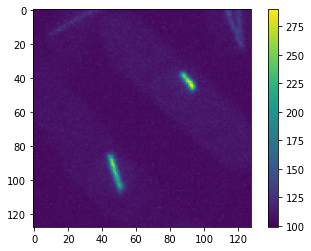

In [268]:
filename = 'test_stack_2.tif'
im = imread(filename)[4]
plt.imshow(im)
plt.colorbar()

In [286]:
def normalise(im):
    im_min = np.min(im)
    im_max = np.max(im)
    return (im-im_min)/(im_max-im_min)

class hough:
    
    def __init__(self, im, n_thetas=180):
        self.im = im
        self.w = im.shape[1]
        self.h = im.shape[0]
        self.n_thetas=n_thetas
        
    def create_accumulator(self):
        self.max_d = int(np.sqrt(self.w**2+self.h**2))
        n_d = 2*self.max_d+1
        self.accumulator = np.zeros((n_d, self.n_thetas))
        self.theta_vals = np.linspace(0, np.pi, self.n_thetas)
        self.d_vals = np.linspace(-self.max_d, self.max_d, n_d)
        
    def populate_accumulator(self, do_weight=True):
        cos_thetas = np.cos(self.theta_vals)
        sin_thetas = np.sin(self.theta_vals)
        
        for y in range(self.h):
            for x in range(self.w):
                if self.im[y,x]==0:
                    continue
                for t in range(self.n_thetas):
                    d = int(x*cos_thetas[t]+y*sin_thetas[t]+self.max_d)
                    
                    if do_weight:
                        self.accumulator[d,t] += self.im[y,x]
                    else:
                        self.accumulator[d,t] += 1.0
        
    def find_peaks(self, min_dist, min_len):
        self.peaks = peak_local_max(self.accumulator, min_distance=min_dist, threshold_abs=min_len, exclude_border=False)
        self.n_peaks = len(self.peaks)
        
    def get_lines(self):
        self.lines_dict = []
        for p in self.peaks:
            val = self.accumulator[p[0]-1,p[1]-1]
            d = p[0]
            t = p[1]
            d_ = d-self.max_d+1
            x0 = d_*np.cos(self.theta_vals[t])
            y0 = d_*np.sin(self.theta_vals[t])
            m = -np.tan(np.pi/2-self.theta_vals[t])
            c = y0 - m*x0
            self.lines_dict.append({'val':val, 'd':d, 'd_':d_, 't': t, 'm': m, 'c':c, 'eq': f'y = {m}*x + {c}'})
    
    def draw_im_and_lines(self):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.imshow(im)
        for p in range(self.n_peaks):
            m = self.lines_dict[p]['m']
            c = self.lines_dict[p]['c']
            ax.plot([0, self.w], [c, m*self.w+c])
        ax.set_xlim([0,self.w-1])
        ax.set_ylim([self.h-1,0])
        
    def draw_accumulator_and_peaks(self):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.imshow(self.accumulator)
        for p in range(self.n_peaks):
            d = self.lines_dict[p]['d']
            t = self.lines_dict[p]['t']
            ax.plot(t, d, 'x', ms=10)
    
    def do_hough(self, do_weight, min_dist, min_len):
        self.create_accumulator()
        self.populate_accumulator(do_weight)
        self.find_peaks(min_dist, min_len)
        self.get_lines()

In [287]:
norm_im = normalise(im)

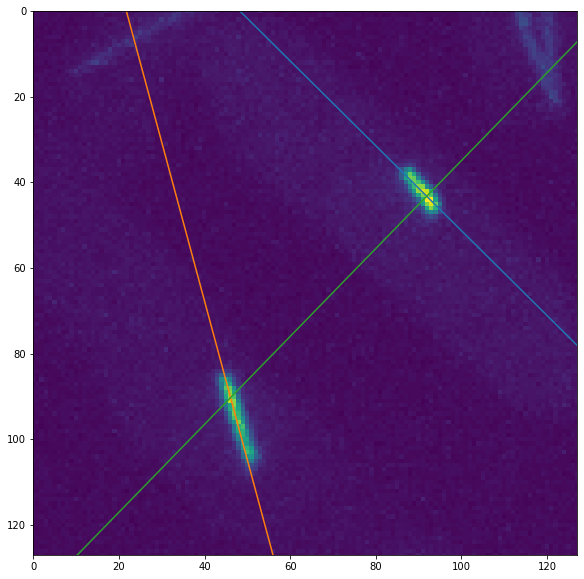

In [291]:
a = hough(norm_im)
a.do_hough(True, 15, 15)
a.draw_im_and_lines()